In [43]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, f1_score, matthews_corrcoef, recall_score, confusion_matrix
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from scipy.special import softmax
from sklearn.svm import SVC


In [45]:
def report (y_test, preds):
    stats = pd.DataFrame()  
    stats['Precision'] = [precision_score(y_test, preds)] 
    stats['Recall'] = [recall_score(y_test, preds)]
    stats['F1'] = [f1_score(y_test, preds)]
    stats['Matthews'] = [matthews_corrcoef(y_test, preds)]
    stats['Accuracy'] = [accuracy_score(y_test, preds)]
    display(stats)
    display(pd.DataFrame(confusion_matrix(y_test, preds), columns=['PP', 'PN'], index=['P', 'N']))

# 1


Tip: scikit-learn has the LogisticRegressionClassifier, DecisionTreeClassifier and the
AdaBoostClassifier class.\


## a) use a regression model to classify (logistic regression) and record the accuracy.

In [3]:
df = datasets.load_breast_cancer()

In [4]:
y = df.target
X = df.data

In [5]:
scaler = StandardScaler()
Xt=scaler.fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=22)


In [7]:
logreg = LogisticRegression(max_iter= 10000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [12]:
preds = logreg.predict(X_test)
print(report(y_test, preds))

,Precision,Recall,F1,Matthews,ACcuracy
0,0.935484,0.988636,0.961326,0.897335,0.951049


None


## b) use AdaBoost with 7 logistic regression base learner experts and compare results.

In [16]:
expert = LogisticRegression()
clf = AdaBoostClassifier(estimator = expert, n_estimators=7, random_state=22)
clf.fit(Xt, y)
preds = clf.predict(X_test)
print(report(y_test, preds))

,Precision,Recall,F1,Matthews,ACcuracy
0,0.956522,1.0,0.977778,0.941784,0.972028


None


- a) accurcy = .951; b) accuracy = .972

## c) compare with other numbers of experts (ex. 3, 10).

In [20]:
experts_list =(3,10)
for i in experts_list:
    clf = AdaBoostClassifier(estimator = expert, n_estimators=i, random_state=22)
    clf.fit(Xt, y)
    preds = clf.predict(X_test)
    print(report(y_test, preds))

,Precision,Recall,F1,Matthews,ACcuracy
0,0.946237,1.0,0.972376,0.927478,0.965035


None


,Precision,Recall,F1,Matthews,ACcuracy
0,0.956044,0.988636,0.972067,0.926302,0.965035


None


## d) repeat a, b and c with decision tree base learner experts. Suggestion: try to use different number of experts, e.g. 15, 17, 20, 23, and so on.

In [25]:
experts_list =(15, 17, 20, 23)

for i in experts_list:
    clf = AdaBoostClassifier(n_estimators=i, random_state=22)
    clf.fit(Xt, y)
    preds = clf.predict(X_test)
    print(report(y_test, preds))

,Precision,Recall,F1,Matthews,ACcuracy
0,0.977778,1.0,0.988764,0.970681,0.986014


None


,Precision,Recall,F1,Matthews,ACcuracy
0,0.988764,1.0,0.99435,0.985285,0.993007


None


,Precision,Recall,F1,Matthews,ACcuracy
0,1.0,1.0,1.0,1.0,1.0


None


,Precision,Recall,F1,Matthews,ACcuracy
0,1.0,1.0,1.0,1.0,1.0


None


# 2 - Implement a Weighted Average Ensemble System in Python.

1) split data:
    - split train / validation
    - split train once more to obtain test set
2) train each expert on train set
    - predict with validation to get each accuracy
3) apply soft max formula to each accuracy to  get the weights 
4) predict experts with test set
    - aply dot prod to this preds and weights
5) compare with the true labels to get the accuracy of the ensembled


In [105]:
df = datasets.load_breast_cancer()

In [106]:
y = df.target
X = df.data

In [107]:
#1st split of Data: To obtain last preds - last phase - (test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=222)

In [108]:

#2nd split of Data: For training and obtain 1st preds to get weights with softmax - first phase - (validation)
X_train_01, X_valid, y_train_01, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=22)

In [96]:
# Lets fit a scaler to the training set
scaler = StandardScaler()
scaler.fit(X_train_01)
scaler.fit(X_valid)
# Lets transform the X's
X_train_01 = scaler.transform(X_train_01)
X_valid = scaler.transform(X_valid)


## 1st phase 
- We need to start by training some experts

In [109]:
# Decision Trees
dt_gini = DecisionTreeClassifier().fit(X_train_01, y_train_01)

dt_entropy = DecisionTreeClassifier(criterion="entropy").fit(X_train_01, y_train_01)

# SVM 
svc_rbf = SVC().fit(X_train_01, y_train_01)

svc_poly = SVC(kernel = "poly").fit(X_train_01, y_train_01)

# Log
logreg_default = LogisticRegression(max_iter = 10000).fit(X_train_01, y_train_01)

logreg_C = LogisticRegression(C=.01,max_iter = 10000).fit(X_train_01, y_train_01)


## 2nd phase 
- With the experts trained we are going to obtain the preds and accuracys using validation set

In [110]:
preds_gini = dt_gini.predict(X_valid)
preds_entropy = dt_entropy.predict(X_valid)

preds_rbf = svc_rbf.predict(X_valid)
preds_poly = svc_poly.predict(X_valid)

preds_log_default = logreg_default.predict(X_valid)
preds_log_C = logreg_C.predict(X_valid)

In [111]:
accuracy_gini= accuracy_score(y_valid, preds_gini)
accuracy_entropy = accuracy_score( y_valid, preds_entropy)

accuracy_rbf= accuracy_score(y_valid, preds_rbf)
accuracy_poly = accuracy_score( y_valid, preds_poly)

accuracy_log_default= accuracy_score(y_valid, preds_log_default)
accuracy_log_C = accuracy_score( y_valid, preds_log_C)

acc = [accuracy_gini, accuracy_entropy, accuracy_rbf, accuracy_poly, accuracy_log_default, accuracy_log_C]
acc

[0.9158878504672897,
 0.9345794392523364,
 0.8785046728971962,
 0.8785046728971962,
 0.9626168224299065,
 0.9532710280373832]

- The next step is to obtain the weights using softmax function in order to get weights corresponding to each expert

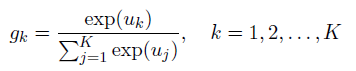

In [112]:
weights = (np.exp(acc)/np.sum(np.exp(acc)))
weights

array([0.16579871, 0.1689269 , 0.15971505, 0.15971505, 0.17373019,
       0.1721141 ])

- we can observe that the highest weight is aatributed to the expert with the highest accuracy value

## 3th phase 
- obtain new preds from experts this time with the test set

In [70]:
preds_gini_test = dt_gini.predict(X_test)
preds_entropy_test = dt_entropy.predict(X_test)

preds_rbf_test = svc_rbf.predict(X_test)
preds_poly_test = svc_poly.predict(X_test)

preds_log_default = logreg_default.predict(X_test)
preds_log_C = logreg_C.predict(X_test)

In [113]:
# Make list of arrays with all the preds from each expert
preds = [preds_entropy_test, preds_gini_test, preds_rbf_test, preds_poly_test, preds_log_default, preds_log_C]
preds

[array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1]),
 array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1]),
 array([1, 1, 1, 0, 1, 1, 

In [72]:
weights

array([0.16098497, 0.16402233, 0.17186883, 0.16098497, 0.17186883,
       0.17027006])

In [73]:
# Get new preds with dot product, rounded
new_preds = np.round(np.dot(weights, preds))

- The final step is to evaluate the quality of the ensembled model. TO do this we will compare the "new_preds" with the true labels and get classification metrics

In [75]:
report(y_test, new_preds)

,Precision,Recall,F1,Matthews,Accuracy
0,0.977778,1.0,0.988764,0.970681,0.986014


,PP,PN
P,53,2
N,0,88


## Conclusion
- It is possible to observe that by using a divide and conquer principle with just six experts (weak models) the accuracy level of the emsembled model wich is derived from  a weighted average, was higher than each of the individuals models. 
    - We this comes a downside wwhich is that there is loss of interpretation capability due to the usage of a averege. With this details / characteristic are lost which would be maintend if a single modle was used.
- Another advantadge of using ensembled average models is that a model with lower variance is obtained, reducing the risk of overfitng when compared with a single model.

